# Classification predict Climate Change


<img src="https://climate.nasa.gov/system/internal_resources/details/original/103_shutterstock_88550854-740px.jpg" width=90%>

# 1. Introduction

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

The task of the predict is to create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Being able to provide an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


# 2. Importing liabraries

In [1]:
!pip install wordcloud

In [75]:
# utilities
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
sns.set()

# nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import nltk
import re

# sklearn(classifier)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

#Metrics/Evaluation
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics


# 3. Uploading the dataset

In [78]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [79]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [80]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# 4. Exploratory Data Analysis

### 4.1 Dataset description

Here is a quick explanation of the columns in the datasets:
* tweetid — the id of the tweet message on Twitter.
* message — the tweet messages for each tweetid
* sentiment — the sentiment of the tweet messages from 2, 1, 0, and -1.


*  The uploaded datasets are train and the test dataset, the train dataset contain three columns which are sentiment,  tweet message and tweetid while the test dataset contains the tweet message and the tweetid column.


*   The sentiment column  has four classes which are represented by four numbers 2, 1, 0, -1, the following picture shows the description of the four classes:


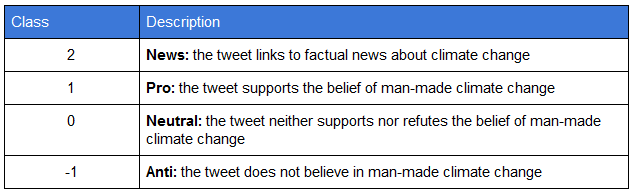

## words in each tweet

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


* There are total 15819 tweets in the train dataset.
All the columns in the dataset have no null values.
Sentiment and tweetid columns consist of integer values, whereas message column is of object data type.  

In [82]:
# look at how many words are there in each tweet message.
train['token_length'] = [len(x.split(" ")) for x in train.message]
train # call train df

,sentiment,message,tweetid,token_length
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,19
1,1,It's not like we lack evidence of anthropogeni...,126103,10
2,2,RT @RawStory: Researchers say we have three ye...,698562,19
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,15
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,18
...,...,...,...,...
15814,1,RT @ezlusztig: They took down the material on ...,22001,22
15815,2,RT @washingtonpost: How climate change could b...,17856,13
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248,19
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732,20


In [83]:
# maximum length
max(train.token_length)

31

* token_lenth column outline number of words that are there in each tweet message. And we see that the maximum length is 31


### 4.2 The distribution of tweets messages over the classes

In [84]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

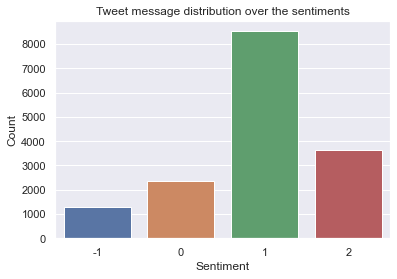

In [108]:
# message  Distribution over the classes
dist_class = train['sentiment'].value_counts()
labels = ['1', '2','0','-1']

# Bar graph plot
sns.barplot(x=dist_class.index, y=dist_class, data = train).set_title("Tweet message distribution over the sentiments")
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()


Text(0.5, 1.0, 'Tweet message distribution over the sentiments')

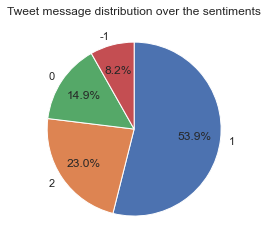

In [110]:
# pie plot
plt.pie(dist_class,
        labels=labels,
        #colors=colors,
        counterclock=False,
        startangle=90,
        autopct='%1.1f%%',
        pctdistance=0.7)
plt.title("Tweet message distribution over the sentiments")


# The visualisations above indicates that :
* There are 8530 tweet messages on count that support the believe of man-made climate change(sentiment: 1), which is 53.9%(shown on pie chat).
* There are 1296 tweet messages on count that does not believe in man-made climate change(sentiment: -1), which is 8.2% on pie chat.
* There are 2353 tweet messages on count where the tweet message neither supports nor refuses the belief of man-made climate change(sentiment: 0), which is 14.9% (see pie chat).
* There is also 3640 tweet messages on count which links factual news about climate change, and gives about 23.0%(see pie chat)
* We then conlude that the distribution of tweets messages are unevenly distributed in the four given classes.
* Hence, we futher conclude that the classes are somehow imbalanced, and this may affect the accuracy of the model(s).
* The imbalance of the classes can be solved by the method called resampling (Downscalling and Upscalling) which  involve modifying the number of observations in each class. 


### 4.3 The distribution of URL per sendiments 

In [111]:
# Convert to lower
train['target']=train['message'].str.lower()

In [112]:
# Find URL
def find_link(string): 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string)
    return "".join(url) 
train['target_url']=train['target'].apply(lambda x: find_link(x))
df=pd.DataFrame(train.loc[train['target_url']!=""]['sentiment'].value_counts()).reset_index()
df.rename(columns={"index": "sentiment", "sentiment": "url_count"})

,sentiment,url_count
0,1,3789
1,2,3199
2,0,794
3,-1,513




*   From the url_count column above one can conclude that most of the people who belive in climate change  has tweet messages that contain most urls, by knowing such websites it can increase the insights which can help in the future marketing strategies



### 4.4 Word-Cloud

Word Clouds from pre-processed data for News,Pro, Netral and Anti tweet messages from our train dataset and display words that occur the most.

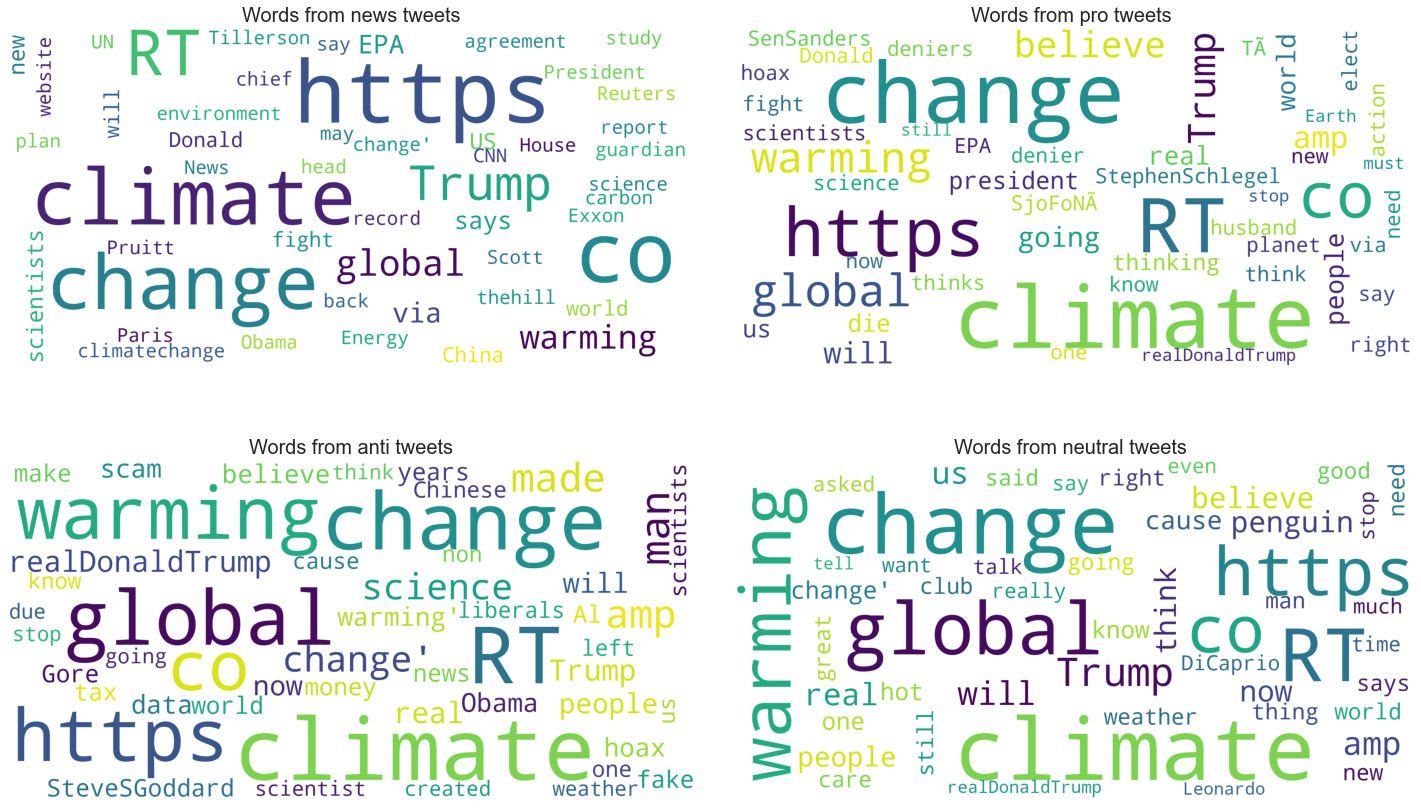

In [74]:
#Plotting word clouds
news = train[train['sentiment'] == 2]['message']
pro = train[train['sentiment'] == 1]['message']
neutral =train[train['sentiment'] == 0]['message']
Anti = train[train['sentiment'] ==-1]['message']


news = [word for line in news for word in line.split()]
pro = [word for line in pro for word in line.split()]
neutral = [word for line in neutral for word in line.split()]
Anti= [word for line in Anti for word in line.split()]

news = WordCloud(
    background_color='white',
    max_words=50,
    max_font_size=50,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(news))

pro = WordCloud(
    background_color='white',
    max_words=50,
    max_font_size=50,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(pro))



neutral = WordCloud(
    background_color='white',
    max_words=50,
    max_font_size=50,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral))


Anti = WordCloud(
    background_color='white',
    max_words=50,
    max_font_size=50,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(Anti))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(news)
axs[0, 0].set_title('Words from news tweets', fontsize = 20)
axs[0, 0].axis('off')
# axs[0, 0].tight_layout(pad = 1)

axs[0, 1].imshow(pro)
axs[0, 1].set_title('Words from pro tweets', fontsize = 20)
axs[0, 1].axis('off')
# axs[0, 1].tight_layout(pad = 1)


# axs[1, 0].tight_layout(pad = 1)
axs[1, 0].imshow(Anti)
axs[1, 0].set_title('Words from anti tweets', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(neutral)
axs[1, 1].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 1].axis('off')

# axs[1, 0].tight_layout(pad = 1)
plt.savefig('joint_cloud.png')

* Climate change seems to be the most frequently used word in all the tweet classes.

* Due to an overlap in frequest words among the classes, there is not much difference that can be drawn from the word cload,we will therefore use frequent words dictionary with top 20 counts for much better information extrapolation.




## 5. Data Preprocessing

 Data preprocessing is a step where we transforms text into a more digestible form so that machine learning algorithms can perform better.The following steps were performed for both the train and the test dataset.
* Checking for nuls: Checking for any nulls in the datasets
* Checking for blanks strings: Checking for any blanks strings in the datasets
* Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
* Lower Casing: Each text is converted to lowercase.
* Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence.
* Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)





## 5.1 Checking for nulls in he dataframes

In [85]:
# Checking Nulls in the train dataframe
train.isnull().sum()

sentiment     0
message       0
tweetid       0
target        0
target_url    0
dtype: int64

In [86]:
# Checking Nulls in the test dataframe
test.isnull().sum()

message    0
tweetid    0
dtype: int64

## 5.2 Checking for blanks in he dataframes

In [87]:
#Checking for blanks in the train dataframe
blanks = []  # start with an empty list
for i,sen,mes,twe in train.itertuples():  # iterate over the DataFrame
    if type(mes)==str:            # avoid NaN values
        if mes.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

ValueError: too many values to unpack (expected 4)

In [89]:
#Checking for blanks in the train dataframe
blanks = []  # start with an empty list
for i,mes,twe in test.itertuples():  # iterate over the DataFrame
    if type(mes)==str:            # avoid NaN values
        if mes.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


## 5.3 Replacing URL

In [90]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
train['message'] = train['message'] .replace(to_replace = pattern_url, value = subs_url, regex = True)
test['message'] = test['message'] .replace(to_replace = pattern_url, value = subs_url, regex = True)

## 5.4 Removing stopwords, lowering the words as well as lemmatizing  for both the train and the test dataframe

In [91]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siyam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\siyam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [92]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub('<[^<]+?>','', text)
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

train['Processed_message'] = train.message.apply(lambda x: clean_text(x))

test['Processed_message'] = test.message.apply(lambda x: clean_text(x))


In [93]:
# Checking the preprossed train dataframe 
train.head()


,sentiment,message,tweetid,target,target_url,Processed_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesn't think carbon di...,https://t.co/yelvcefxkc,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,it's not like we lack evidence of anthropogeni...,,like lack evidence anthropogenic global warm
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt @rawstory: researchers say we have three ye...,https://t.co/wdt0kdur2fhttps://t.co/z0anpt,rt rawstory researcher say three year act clim...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#todayinmaker# wired : 2016 was a pivotal year...,https://t.co/44wotxtlcd,todayinmaker wire 2016 wa pivotal year war cl...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"rt @soynoviodetodas: it's 2016, and a racist, ...",,rt soynoviodetodas 2016 racist sexist climate ...


In [94]:
# Checking the preprossed test dataframe 
test.head()

,message,tweetid,Processed_message
0,Europe will now be looking to China to make su...,169760,europe look china make sure alone fight climat...
1,Combine this with the polling of staffers re c...,35326,combine poll staffer climate change woman righ...
2,"The scary, unimpeachable evidence that climate...",224985,scary unimpeachable evidence climate change al...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos \nputin ge...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,rt fakewillmoore female orgasm cause global wa...


# Machine Learning

Now we employ machine-learning technique and diverse features to construct a classifier that can identify text/messages that expresses sentiment.

## 6. Defining variables

In [96]:
#Independent feature of the train dataframe
X=train['Processed_message']
#Dependent feature of the train dataframe
y=train['sentiment'] 
#Independent feature of test dataframe
x_unseen=test['Processed_message'] #test independent feature

## 7. Splitting the dataset

The Preprocessed Data is divided into 2 sets of data:

*   Training Data: The dataset upon which the model would be trained on. Contains 90% data. 
*   Test Data: The dataset upon which the model would be tested against. Contains 10% data.




In [97]:
#Splitting the train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## 8. Model fitting


## 8.1 Parameters  and TF-IDF Vectoriser explanation
**TF-IDF Vectoriser**
* TF-IDF indicates what the importance of the word is in order to understand the document or dataset.

* TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features.

* **ngram_range** is the range of number of words in a sequence.

* **max_df** Used for removing data values that appear too frequently.

* **min_df** Used for removing terms that appear too infrequently.



In [98]:
vectoriser = TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))

In [99]:
#fitting the vectoriser
vectoriser.fit(X_train, y_train) 

TfidfVectorizer(max_df=0.9, ngram_range=(1, 2), stop_words='english')

* Transforming the **X_train** and **X_test dataset** into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.

In [100]:
#transformation of the datasets
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

## 8.2 Models Descriptions

We have chosen the following models to train and test our data:
1. **Logistic Regression:**
Logistic regression is a statistical model that in its basic form uses a logistic function to model the probability of a certain class 

2. **LineasrSVC:**
Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and  scale better to large numbers of samples.This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

3. **Multinomial Naive Bayes:** 
Naive Bayes classifier for multinomial models. The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

4. **Support Vector Machine:**
The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.we have used the rbf kernel, which allows the SVC to fit a non-linear decision boundary. 
5. **BernoulliNB** ...


### 8.3 Pipelines for fitting the models

## 8.3.1 Logistic Regression Model

In [101]:
LogisticRegression = LogisticRegression()

##Fitting the model with train dataset
LogisticRegression = LogisticRegression.fit(X_train, y_train)

C:\Users\siyam\Anaconda3\New folder\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [102]:
# Getting predicions from the X_test
pred = LogisticRegression.predict(X_test)
#Pritting the classification report
print(metrics.classification_report(y_test,pred))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,pred))

              precision    recall  f1-score   support

          -1       0.80      0.35      0.49       126
           0       0.67      0.33      0.45       224
           1       0.76      0.88      0.82       895
           2       0.73      0.80      0.76       337

    accuracy                           0.75      1582
   macro avg       0.74      0.59      0.63      1582
weighted avg       0.74      0.75      0.73      1582

0.7458912768647282


## 8.3.2 LinearSVC Model

In [103]:
LinearSVC = LinearSVC()

##Fitting the model with train dataset
LinearSVC = LinearSVC.fit(X_train, y_train)

In [104]:
# Getting predicions from the X_test
pred1 = LinearSVC.predict(X_test)
#Printing the classification report
print(metrics.classification_report(y_test, pred1))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,pred1))

              precision    recall  f1-score   support

          -1       0.70      0.50      0.58       126
           0       0.66      0.38      0.48       224
           1       0.79      0.87      0.83       895
           2       0.75      0.83      0.79       337

    accuracy                           0.76      1582
   macro avg       0.72      0.65      0.67      1582
weighted avg       0.75      0.76      0.75      1582

0.7629582806573957


## 8.3.3 Support Vector Machine Model

In [105]:
SVC = SVC()

##Fitting the model with train dataset
SVC = SVC.fit(X_train, y_train)

In [106]:
# Getting predictions from the X_test
pred2 = SVC.predict(X_test)
#Pritting the classification report
print(metrics.classification_report(y_test,pred2))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,pred2))

              precision    recall  f1-score   support

          -1       0.89      0.32      0.47       126
           0       0.79      0.29      0.43       224
           1       0.73      0.91      0.81       895
           2       0.76      0.78      0.77       337

    accuracy                           0.75      1582
   macro avg       0.79      0.58      0.62      1582
weighted avg       0.76      0.75      0.72      1582

0.7484197218710493


## 8.3.4 Multinominal Naive Bayes Model

In [107]:
MultinomialNB = MultinomialNB()

##Fitting the model with train dataset
MultinomialNB  = MultinomialNB .fit(X_train, y_train)

In [108]:
# Getting predictions from the X_test
pred3 = MultinomialNB.predict(X_test)
#Priting the classification report
print(metrics.classification_report(y_test,pred3))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,pred3))

              precision    recall  f1-score   support

          -1       1.00      0.04      0.08       126
           0       1.00      0.03      0.06       224
           1       0.63      0.99      0.77       895
           2       0.92      0.45      0.60       337

    accuracy                           0.66      1582
   macro avg       0.89      0.38      0.38      1582
weighted avg       0.77      0.66      0.58      1582

0.661188369152971


## 8.3.4 BernoulliNB Model

In [109]:
BNBmodel = BernoulliNB(alpha = 2)

##Fitting the model with train dataset
BNBmodel.fit(X_train, y_train)

BernoulliNB(alpha=2)

In [110]:
# Getting predictions from the X_test
pred4 = BNBmodel.predict(X_test)
#Priting the classification report
print(metrics.classification_report(y_test,pred4))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,pred4))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       126
           0       0.00      0.00      0.00       224
           1       0.57      1.00      0.73       895
           2       1.00      0.03      0.06       337

    accuracy                           0.57      1582
   macro avg       0.39      0.26      0.20      1582
weighted avg       0.54      0.57      0.42      1582

0.5720606826801518


C:\Users\siyam\Anaconda3\New folder\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 9. Evaluation metrics 

As a classification problem, Sentiment Analysis uses the evaluation metrics of Precision, Recall, F-score, and Accuracy. Also, average measures like macro, micro, and weighted F1-scores are useful for multi-class problems.

## 10. Results Visualization

## 11. Conclusion

Based on the accuracy scores from the four  fitted models above, LinearSCV is the one which gives a higher score than the rest implyng that is the best model to use to predict the sentiment of the tweet messages. Based on the model description on 8.2 it states that LinearSCV supports both dense and sparse input and the multiclass  is handled according to a one-vs-the-rest ,this is the reason why is the best model.

## 12. Predicting the sentiment from the test dataset based on the best model

In [ ]:
#Getting the predicted sentimet from test dataset
y_pred = LinearSVC.predict(x_unseen)

In [ ]:
#Printing the predicted sentiment
y_pred

#11. Submissions

In [ ]:
#Making the tweetid to be the idex
test=test.set_index('tweetid')

In [ ]:
test.head(5)

In [ ]:
#Sellecting the index of the test dataframe
final_test= test.index

In [ ]:
#Creating the submission Dataframe
Final_Table = {'tweetid': final_test, 'sentiment':np.round(y_pred, 0)}
submission = pd.DataFrame(data=Final_Table)
submission = submission[['tweetid', 'sentiment']]

In [ ]:
submission.set_index('tweetid').head(5)

In [ ]:
submission.to_csv("TestSubmission7.csv",index  = False) #wrting csv file

### Saving models


In [35]:
import pickle
file = open('vectoriser-ngram-(1,2).pkl','wb')
pickle.dump(vectoriser, file)
file.close()


In [36]:

file = open('BNBmodel.pkl','wb')
pickle.dump(BNBmodel, file)
file.close()


In [37]:

file = open('LogisticRegression.pkl','wb')
pickle.dump(LogisticRegression, file)
file.close()


In [72]:

file = open('SVC.pkl','wb')
pickle.dump(SVC, file)
file.close()


In [73]:

file = open('MultinomialNB.pkl','wb')
pickle.dump(MultinomialNB, file)
file.close()


In [74]:

file = open('LinearSVC.pkl','wb')
pickle.dump(LinearSVC, file)
file.close()
